## <b><font color='darkblue'>Preface</font></b>
([source](https://medium.com/vectrix-ai/image-extraction-with-langchain-and-gemini-a-step-by-step-guide-02c79abcd679)) <b><font size='3ptx'>In this post, we’ll explore creating an image metadata extraction pipeline using Langchain and the multi-modal LLM Gemini-Flash-1.5. We’ll also demonstrate a method for ensuring the generated output contains enough variations, which is crucial for improving SEO and user experience.</font></b>

<b>Doyou have a large collection of images that you want to annotate using a language model? This guide will walk you through leveraging Langchain and Gemini-Flash-1.5 to extract content from images and return structured attributes. </b>

<b>We’ve implemented this for a large online retailer, processing thousands of product images</b>. By describing the images and extracting additional attributes like color and SEO (Search engine optimization) hashtags, we can generate structured data that enhances user experience and SO ranking when uploaded to an e-commerce site.

We use a combination of LLMs for various sub-tasks and Langchain to efficiently parse the LLM output. Langchain also boosts performance by running operations in parallel.
![flow](images/image1_flow.PNG)

In [6]:
#!pip install -q -U google-generativeai # Install the Python SDK

In [14]:
!pip freeze | grep -P '(google-generativeai|langchain-google-genai)'

google-generativeai==0.7.2
langchain-google-genai==2.0.0


In [8]:
import google.generativeai as genai
import os
from dotenv import load_dotenv, find_dotenv
from typing import Any


_ = load_dotenv(find_dotenv(os.path.expanduser('~/.env'))) # read local .env file
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

### <b><font color='darkgreen'>Our images</font></b>
For the case example, I have taken pictures of some fruit; we’ll use them to create an extraction pipeline and try annotating them using an LLm.

In [1]:
# Images to extract data from
fruits = ['https://storage.googleapis.com/vectrix-public/fruit/apple.jpeg',
          'https://storage.googleapis.com/vectrix-public/fruit/banana.jpeg',
          'https://storage.googleapis.com/vectrix-public/fruit/kiwi.jpeg',
          'https://storage.googleapis.com/vectrix-public/fruit/peach.jpeg',
          'https://storage.googleapis.com/vectrix-public/fruit/plum.jpeg']

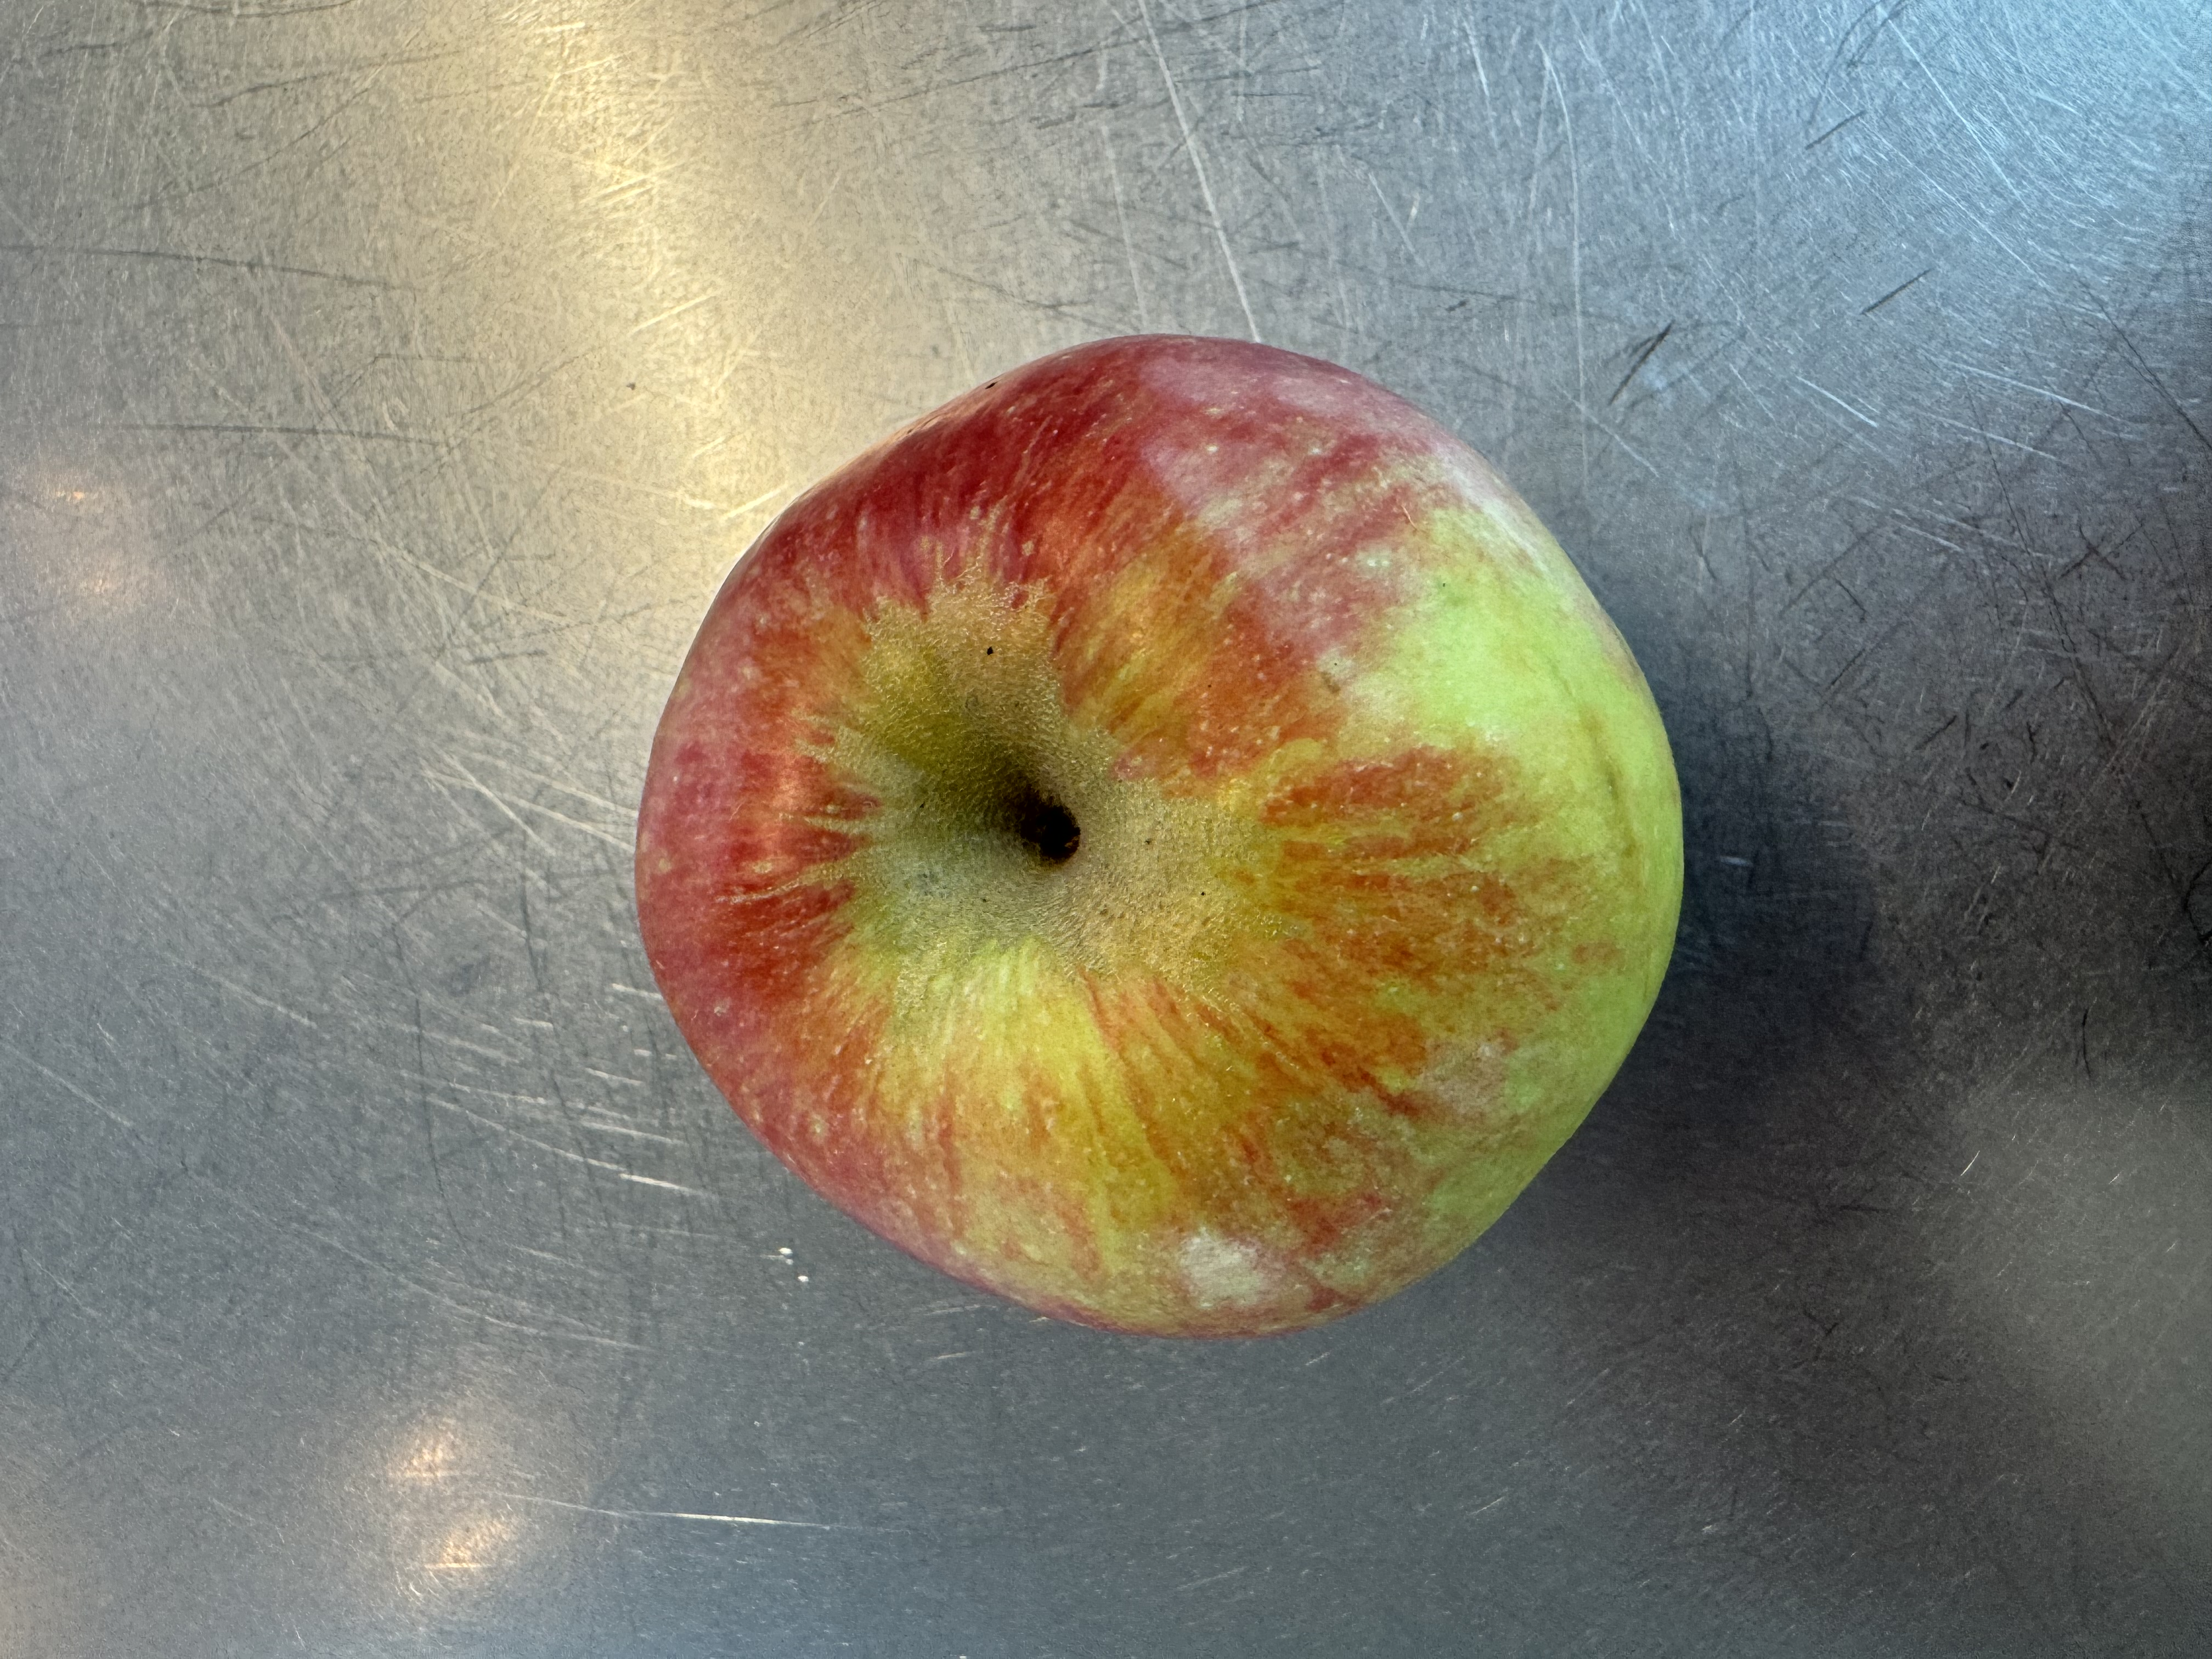

In [5]:
from IPython.display import Image

Image(fruits[0], width=200, height=200)

## <b><font color='darkblue'>Passing an Image Directly to the Model</font></b>
We can pass an image directly to an LLM without using Langchain. Let’s test this with the Gemini Flash model and see how it responds. Make sure to set your API key as an environment variable named `GOOGLE_API_KEY`.

### <b><font color='darkgreen'>Example Code</font></b>

In [10]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
import base64, httpx

In [15]:
# Initialize the model
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [16]:
# Download and encode the image
image_data = base64.b64encode(httpx.get(fruits[0]).content).decode("utf-8")

In [19]:
image_data[:100]

'/9j/4AAUSkZJRgABAQEBLAEsAABBTVBG/+EnE0V4aWYAAE1NACoAAAAIAAwBDwACAAAABgAAAJ4BEAACAAAADgAAAKQBEgADAAAA'

In [17]:
# Create a message with the image
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "describe the fruit in this image"
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)

In [20]:
# Invoke the model with the message
response = model.invoke([message])

In [21]:
# Print the model's response
print(response.content)

The fruit is an apple. It is red and yellow in color, with a slightly green tinge. The apple has a small stem and a dimple in the center. The apple appears to be ripe and ready to eat.


### <b><font color='darkgreen'>How It Works</font></b>
The model responds with a detailed description of the fruit in the image. For example:
> The fruit is an apple. It is red and yellow, with a small stem on top...

<br/>

Below explains the example code above:
1. **Initialize the Model**: We use the [**ChatGoogleGenerativeAI**](https://python.langchain.com/docs/integrations/chat/google_generative_ai/) package from [**Langchain**](https://github.com/langchain-ai/langchain) to initialize the Gemini Flash model.
2. **Download and Encode the Image**: The image is downloaded and encoded using base64 encoding.
3. **Create the Message**: We create a HumanMessage that includes both a text prompt and the encoded image.
4. **Invoke the Model**: The model is invoked with the message, and it processes the image to generate a description.
5. **Print the Response**: The response from the model is printed, providing a detailed description of the fruit.

By using the [**ChatGoogleGenerativeAI**](https://python.langchain.com/docs/integrations/chat/google_generative_ai/) package, we can directly interact with the Gemini Flash model, passing images and receiving descriptive responses. This approach allows us to quickly test the model's capabilities and understand how it handles image inputs.

Now that we have images and know how to call the model let’s set up the extraction pipeline.

## <b><font color='darkblue'>Build A Pipeline To Extract Metadata of Images</font></b>

### <b><font color='darkgreen'>Step 1: Define the output structure</font></b>
<b><font size='3ptx'>The next step is to extract structured data from the image. </font></b>

<b>We can achieve this by combining a [Pydantic](https://docs.pydantic.dev/latest/) parser with a multi-modal message</b>. First, we define a [**Pydantic data model**](https://docs.pydantic.dev/latest/concepts/models/) and then pass that on to the model to extract structured data from the image.

#### <b>Defining the Data Model</b>
We use [Pydantic to define a data model](https://docs.pydantic.dev/latest/concepts/models/), which helps ensure that the extracted data is structured and validated. In this example, we <b>define a Fruit model with fields for the name, color, taste, and marketing description of the fruit shown in the image</b>.

In [43]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic  import BaseModel, Field

In [44]:
# Define a Pydantic model to parse the model's output
class Fruit(BaseModel):
    name: str = Field(description="The name of the fruit shown in the image")
    color: str = Field(description="The color of the fruit shown in the image")
    taste: str = Field(description="The taste of the fruit shown in the image")
    marketing_description: str = Field(description="A marketing description of the fruit shown in the image")

parser = PydanticOutputParser(pydantic_object=Fruit)

In [45]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"name": {"description": "The name of the fruit shown in the image", "title": "Name", "type": "string"}, "color": {"description": "The color of the fruit shown in the image", "title": "Color", "type": "string"}, "taste": {"description": "The taste of the fruit shown in the image", "title": "Taste", "type": "string"}, "marketing_description": {"description": "A marketing description of the fruit shown in the image", "title": "Marketing Description", "type": "string"}}, "required": ["name", "color", "taste", "marketing_des

#### <b>Setting Up the Prompt</b>
We create a prompt using [**ChatPromptTemplate**](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html) that asks the model to return a response in the desired JSON structure. The prompt includes system and human messages, where the human message provides the image URL encoded in base64.

In [38]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Return the requested response object in {language}.\n'{format_instructions}'\n"),
    ("human", [
        {
            "type": "image_url",
            "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
        },
    ]),
])

#### <b>Combining the Prompt, Model, and Parser</b>
We then combine the prompt, model, and parser into a chain. The model processes the image and returns the data in JSON format, which the <b><font color='blue'>PydanticOutputParser</font></b> then parses and validates against the <b><font color='blue'>Fruit</font></b> data model.

In [39]:
chain = prompt | model | parser

# Retrieve the encoded image data
image_data = base64.b64encode(httpx.get(fruits[3]).content).decode("utf-8")

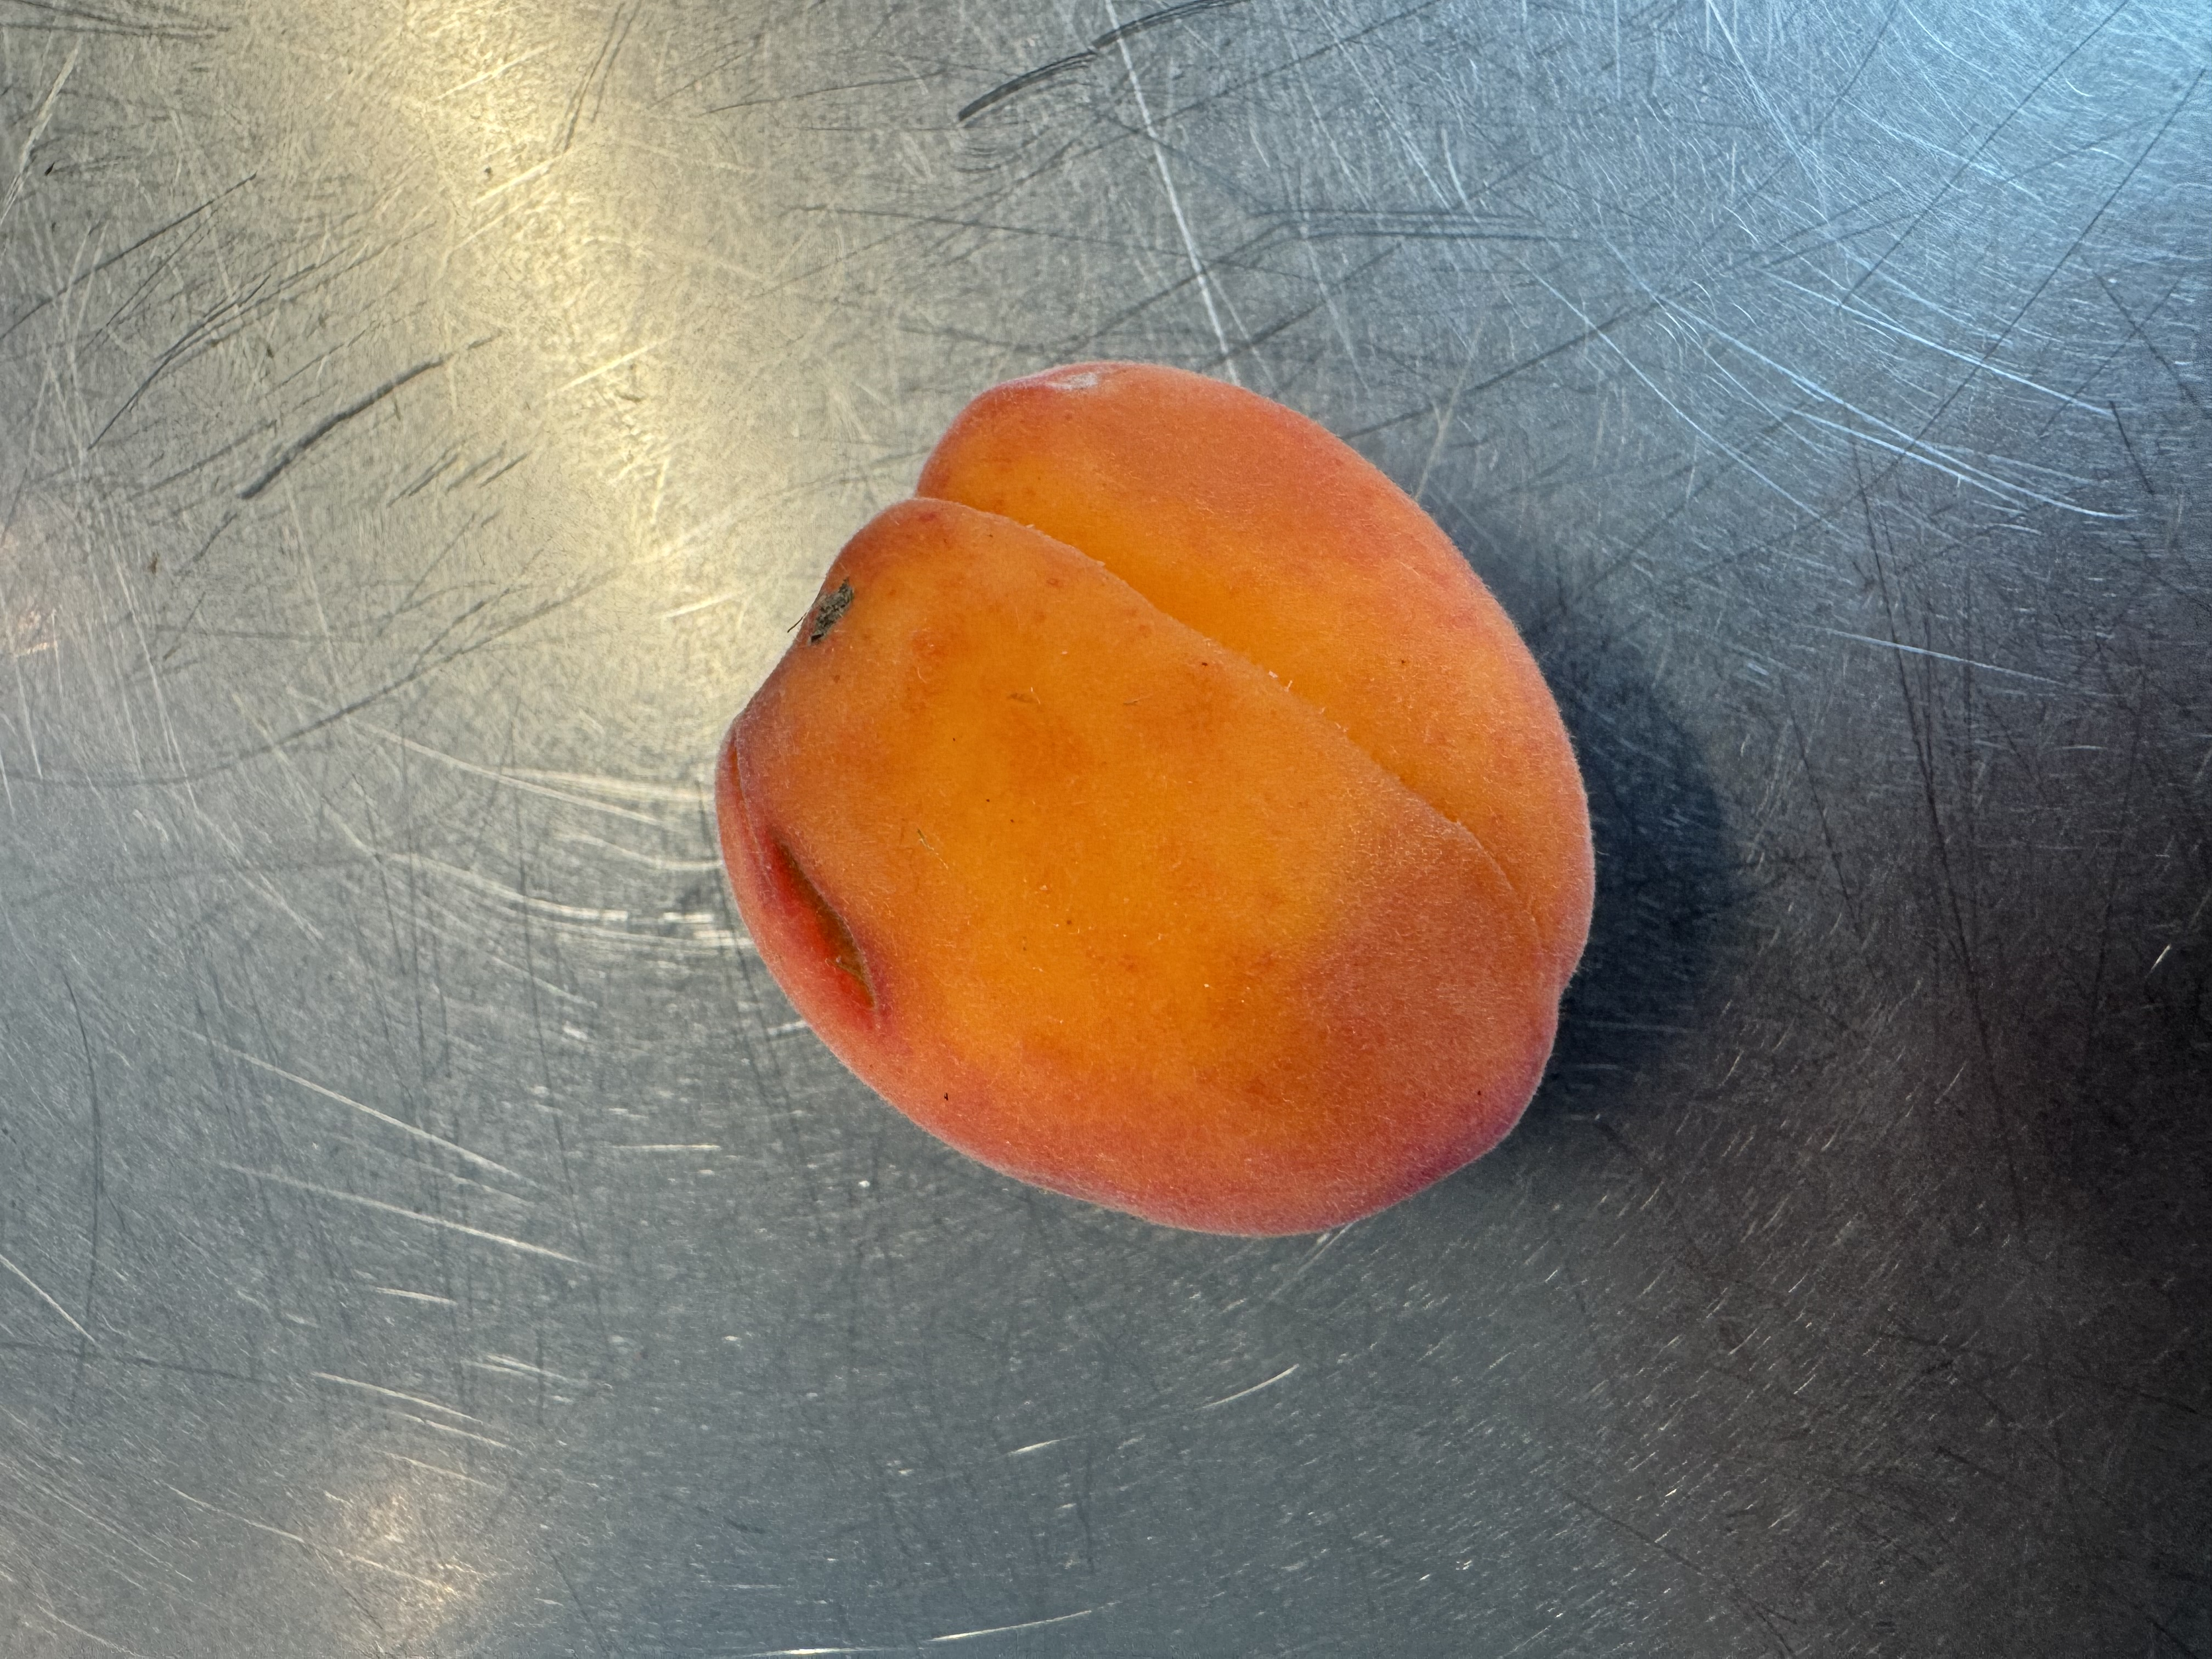

In [34]:
Image(fruits[3], width=200, height=200)

In [46]:
response = chain.invoke({
    "language": "English",
    "format_instructions": parser.get_format_instructions(),
    "image_data": image_data
})

So far we have achieved:
1. **Prompt Creation**: The [**ChatPromptTemplate**](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html) constructs a prompt instructing the model to respond in a specific JSON format.
2. **Model Processing**: The multi-modal LLM, [**Gemini-Flash-1.5**](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash), processes the image and generates a JSON response containing the structured data.
3. **Parsing and Validation**: The [**PydanticOutputParser**](https://api.python.langchain.com/en/latest/core/output_parsers/langchain_core.output_parsers.pydantic.PydanticOutputParser.html) parses the JSON response and validates it against the <b><font color='blue'>Fruit</font></b> data model, ensuring the data is correctly structured and adheres to the defined schema.

As seen in the example above, we create a new chain combining a prompt, an image, and format instructions that ask the model to return a response in the desired JSON structure. We then use a [**PydanticOutputParser**](https://api.python.langchain.com/en/latest/core/output_parsers/langchain_core.output_parsers.pydantic.PydanticOutputParser.html) to extract the JSON from the LLM response and load it as a dictionary. The final response object looks like this:

In [48]:
print(response.json(indent=2))

{
  "name": "Apricot",
  "color": "Orange",
  "taste": "Sweet",
  "marketing_description": "A juicy and flavorful apricot, perfect for a summer snack or dessert. Enjoy its sweet and tangy taste, and its vibrant orange color."
}


### <b><font color='darkgreen'>Step 2: Processing the images in parallel</font></b>
<b><font size='3ptx'>The pipeline we defined in the first step works great but can be slow if you want to process thousands of images. </font></b>

Since it can take multiple seconds to parse a single image, running this sequentially for large datasets can take hours or even days. <b>The solution for this is parallel processing, and fortunately, Langchain has a solution for this: the `chain.batch` function.</b>

#### <b>Running the Chain in Parallel</b>
To run the chain in parallel for all the images, we first prepare a list of dictionaries containing the necessary data for each image. We then use the `batch` method on our chain, which allows us to process multiple images simultaneously.

In [49]:
# Prepare the list of image data dictionaries
all_images = [{"language": "English", 
               "format_instructions": parser.get_format_instructions(),
               "image_data": base64.b64encode(httpx.get(url).content).decode("utf-8")} 
              for url in fruits]

How It Works:
1. **Prepare Data**: We create a list of dictionaries, each containing the language, format instructions, and base64-encoded image data for each image URL.
2. **Parallel Processing**: By using the `batch` method on our chain, we can process all extraction requests in parallel. The <font color='violet'>max_concurrency</font> The config option helps manage the number of concurrent requests to avoid hitting the model API's rate limits.
3. **Retrieve Results**: The results object contains a list of dictionaries with the extracted data for each image.

#### <b>Example Output</b>
The results object will contain structured data for each image, similar to the following examples:
```json
{
  "name": "Apple",
  "color": "Red and Green",
  "taste": "Sweet and Tart",
  "marketing_description": "A crisp and juicy apple with a sweet and tart flavor. Perfect for snacking or baking."
}
{
  "name": "Banana",
  "color": "Yellow",
  "taste": "Sweet",
  "marketing_description": "A delicious and nutritious fruit, perfect for a quick snack or a healthy breakfast. Our bananas are ripe and ready to eat, with a sweet and creamy flavor that everyone will love."
}
...
```

### <b><font color='darkgreen'>Step 3: Ensure the Output Contains Enough Variations</font></b>
<b><font size='3ptx'>Asseen in the examples above, descriptions can be very similar.</font></b>

Language models generate similar output given the same prompt for a similar task. <b>While adjusting the model's temperature might mitigate this, it can also risk breaking the JSON structure if set too high.</b>

Similar output isn’t great for SEO purposes, so we must ensure the model generates unique descriptions. We can achieve some variation by forcing our model to start the output with a random letter and length. Here are the functions we use for this:

In [50]:
import random

def generate_random_letter():
    letters = ['A', 'B', 'C', 'D', 'M', 'P', 'R', 'S', 'T']
    return str(random.choice(letters))

def generate_random_number():
    return int(random.randint(30, 45))

#### <b>Updating the Prompt</b>
First, we update our prompt to include variables for the starting letter and the length.

In [51]:
# A new prompt template that includes the marketing description starting with a given letter
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "Return the requested response object in {language}. Make sure the marketing description starts with the letter"
        " '{starting_letter}'\n'{format_instructions}'\n"
    ),
    (
        "human", [
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
            },
        ],
    )
])

#### <b>Adding Randomness to the Batch</b>
Next, we update the dictionary used to call the batch so that it includes some randomness in our prompt.

In [52]:
# Prepare the list of image data dictionaries with added randomness
all_images = [{"language": "English", 
               "format_instructions": parser.get_format_instructions(),
               "image_data": base64.b64encode(httpx.get(url).content).decode("utf-8"),
               "starting_letter": generate_random_letter()} 
              for url in fruits]

chain = prompt | model | parser

In [53]:
# Run the chain in parallel with a specified max concurrency
results = chain.batch(all_images, config={"max_concurrency": 5})

In [59]:
# Print the results
for result in results:
    print(f'{result.name}: {result.marketing_description}')
    print('\n')

Apple: Mmmmm... juicy and delicious! This apple is the perfect snack for any time of day. It's crisp, refreshing, and packed with flavor. Enjoy it on its own or add it to your favorite recipes.


Banana: Craving a sweet and satisfying snack? Our ripe bananas are the perfect choice! Enjoy them on their own, add them to smoothies, or bake them into delicious treats.  Our bananas are sustainably grown and packed with essential nutrients, making them a healthy and delicious choice for everyone.


Kiwi: Rich in vitamin C and potassium, our kiwis are the perfect addition to your breakfast, lunch, or snack time.  Enjoy them on their own or use them in smoothies, salads, or desserts.  The unique flavor and texture will make you crave more!


Apricot: Perfect for a healthy snack or a delicious dessert, our apricots are bursting with flavor and sunshine. Pick one up today!


Plum: Deliciously juicy and bursting with flavor, our plums are the perfect snack or addition to your favorite desserts.  

How It Works:
1. **Generate Random Values**: We use `generate_random_letter` Create a random starting letter for each description to ensure output variation.
2. **Update Prompt**: The prompt includes the starting letter variable, forcing the model to begin the marketing description with this letter.
3. **Parallel Processing with Randomness**: By adding the starting letter to each dictionary in the `all_images` list, we introduce variation into our batch processing.

By incorporating randomness into the prompt, we can ensure that the model generates unique and varied descriptions, which is beneficial for SEO purposes.